In [256]:
# !pip install siuba
!pip install git+git://github.com/arviz-devs/arviz.git

  Cloning git://github.com/arviz-devs/arviz.git to /tmp/pip-req-build-pnl43tcw
  Running command git clone -q git://github.com/arviz-devs/arviz.git /tmp/pip-req-build-pnl43tcw
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [257]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs

from jax import numpy as jnp
from jax.random import PRNGKey
from jax.scipy.special import expit

import numpy as np
from numpy.random import default_rng

import pandas as pd
import seaborn as sns
import arviz as az

from siuba import _, mutate, group_by, summarize, spread, gather

def make_arviz_data(mcmc, model, *args):
    posterior_samples = mcmc.get_samples()

    posterior_predictive = Predictive(model, posterior_samples)(
        random.PRNGKey(1), *args
    )
    prior = Predictive(model, num_samples=500)(
        random.PRNGKey(2), *args
    )

    return az.from_numpyro(
        mcmc,
        prior = prior,
        posterior_predictive = posterior_predictive
    )
# %run -i 'model_helpers.py'

log_evid_ratio = 1.0986123


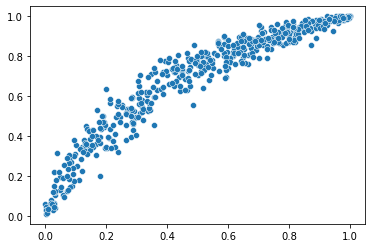

In [214]:
def odds(x):
    return x/(1-x)

def log_odds(x):
    return jnp.log(odds(x))

def prob(x_odds):
    return x_odds/ (1+x_odds)

def add_noise(rng, p, k):
    return rng.beta(p*k, (1-p)*k)

def calc_ptn_prob(prob, d):
    return ((1 - 2*d)*prob  + d)

def infer_prob_ptn(ptn, d):
    return (ptn-d)/(1-2*d)

rng = default_rng(0)

n_obs = 500
d_par = .1
evid_ratio = jnp.exp(jnp.log(3))

prior_cred = rng.beta(1, 1, n_obs)
posterior_cred = prob(np.exp(log_odds(prior_cred) + np.log(evid_ratio)))

df = pd.DataFrame({
    "prior_cred": prior_cred,
    "posterior_cred": posterior_cred,
    "prior_obs": add_noise(rng, calc_ptn_prob(prior_cred, d_par), 100),
    "posterior_obs": add_noise(rng, calc_ptn_prob(posterior_cred, d_par), 100)
})

sns.scatterplot(x=add_noise(rng, df.prior_cred, 100), y=add_noise(rng, df.posterior_cred, 100))
print("log_evid_ratio =", jnp.log(evid_ratio))

<AxesSubplot:xlabel='prior_obs', ylabel='posterior_obs'>

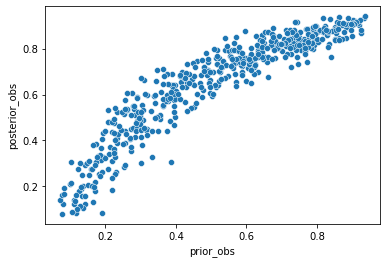

In [215]:
sns.scatterplot(x = df.prior_obs, y = df.posterior_obs)

## Recovering evidence ratio with known noise parameters

* $d$ = reading noise in reporting probabilities (assumed known)
* and response noise for both prior and posterior (unknown)

If you know $d$, can estimate!

In [211]:
infer_prob_ptn(.99, d_par)

1.1125

In [219]:
def model(d, x, y):
    
    k = numpyro.sample("k", dist.HalfCauchy(20))
    log_evid_ratio = numpyro.sample("log_evid_ratio", dist.Normal(0,3))
    
    with numpyro.plate("data", x.shape[0]):
        prior_cred = numpyro.sample("prior", dist.Beta(1,1)) # don't need a latent, can just calculate? <-- only if you assume there's no noise
    # prior_cred = infer_prob_ptn(x, d)
        posterior_cred = prob(jnp.exp(log_odds(prior_cred) + log_evid_ratio))
        prior_obs = calc_ptn_prob(prior_cred, d)
        posterior_obs = calc_ptn_prob(posterior_cred, d)
    
    with numpyro.plate("data", x.shape[0]):
        numpyro.sample("prior_obs", dist.Beta(prior_obs*k, (1-prior_obs)*k), obs = x )
        numpyro.sample("posterior_obs", dist.Beta(posterior_obs*k, (1-posterior_obs)*k), obs=y )
    

In [220]:
kernel = NUTS(model)
mcmc = MCMC(kernel, 2000, 2000, num_chains=1)

mcmc.run(random.PRNGKey(0), d_par, df.prior_obs.to_numpy(), df.posterior_obs.to_numpy())

sample: 100%|██████████| 4000/4000 [00:25<00:00, 159.67it/s, 15 steps of size 2.24e-01. acc. prob=0.85]


In [221]:


azdf = make_arviz_data(mcmc, model, d_par, df.prior_cred.to_numpy(), df.posterior_obs.to_numpy())

In [223]:
az.summary(azdf, var_names=["log_evid_ratio", "k"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_evid_ratio,1.081,0.022,1.042,1.124,0.001,0.000,1052.0,1285.0,NaN
k,101.046,6.496,88.467,112.485,0.219,0.155,877.0,971.0,NaN


This recovers it right!

In [224]:
def model2(x, y):
    
    d = numpyro.sample("d", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(20))
    log_evid_ratio = numpyro.sample("log_evid_ratio", dist.Normal(0,3))

    with numpyro.plate("data", x.shape[0]):
        prior_cred = numpyro.sample("prior", dist.Beta(1,1))

        posterior_cred = prob(jnp.exp(log_odds(prior_cred) + log_evid_ratio))
        prior_obs = calc_ptn_prob(prior_cred, d/2)
        posterior_obs = calc_ptn_prob(posterior_cred, d/2)

        numpyro.sample("prior_obs", dist.Beta(prior_obs*k, (1-prior_obs)*k), obs=x )
        numpyro.sample("posterior_obs", dist.Beta(posterior_obs*k, (1-posterior_obs)*k), obs=y )

In [171]:
kernel = NUTS(model2)
mcmc2 = MCMC(kernel, 2000, 2000, num_chains=1)

mcmc2.run(random.PRNGKey(0), df.prior_obs.to_numpy(), df.posterior_obs.to_numpy())

sample: 100%|██████████| 4000/4000 [00:36<00:00, 110.73it/s, 15 steps of size 2.47e-01. acc. prob=0.83]


In [172]:
azdf2 = make_arviz_data(mcmc2, model2, df.prior_cred.to_numpy(), df.posterior_obs.to_numpy())
az.summary(azdf2, var_names=["log_evid_ratio", "k", "d"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_evid_ratio,1.261,0.038,1.195,1.335,0.002,0.001,355.0,631.0,NaN
k,94.690,6.425,83.188,107.247,0.305,0.216,440.0,1010.0,NaN
d,0.271,0.011,0.250,0.290,0.001,0.000,279.0,514.0,NaN


Looks like estimating d biases estimates for both evidence ratio and estiamtes for d. But I don't really understand because the posterior doesn't look that bad

/opt/conda/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='log_evid_ratio', ylabel='d'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


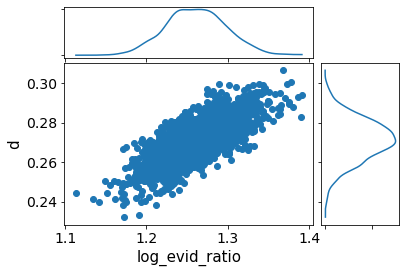

In [174]:
az.plot_joint(azdf2, var_names=["log_evid_ratio", "d"])

In [225]:
az.loo(azdf2, pointwise=True, scale="deviance", var_name="posterior_obs")
# azdf2

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 by 500 log-likelihood matrix

             Estimate       SE
deviance_loo -1486.05    28.99
p_loo          152.26        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      320   64.0%
 (0.5, 0.7]   (ok)        116   23.2%
   (0.7, 1]   (bad)        59   11.8%
   (1, Inf)   (very bad)    5    1.0%

In [227]:
## a simple linear model

def linModel(x,y):
    a = numpyro.sample("a", dist.Normal(0,1))
    b = numpyro.sample("b", dist.Normal(0,1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    
    yhat = a + b*x
    
    with numpyro.plate("data", x.shape[0]):
        numpyro.sample("posterior_obs", dist.Normal(yhat, sigma), obs=y)

In [228]:
kernel = NUTS(linModel)
mcmc3 = MCMC(kernel, 2000, 2000, num_chains=1)

mcmc3.run(random.PRNGKey(0), df.prior_obs.to_numpy(), df.posterior_obs.to_numpy())

sample: 100%|██████████| 4000/4000 [00:04<00:00, 869.72it/s, 15 steps of size 2.86e-01. acc. prob=0.93] 


In [259]:
azdf3 = make_arviz_data(mcmc3, linModel, df.prior_cred.to_numpy(), df.posterior_obs.to_numpy())
az.loo(azdf3, pointwise=True, scale="deviance", var_name="posterior_obs")
# az.compare({"model":azdf2, "lin":azdf3, "var_name":"posterior_obs"}, scale="deviance")

Computed from 2000 by 500 log-likelihood matrix

             Estimate       SE
deviance_loo -1060.85    32.34
p_loo            3.28        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      500  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

The correct model appears to beat the basic `linModel()`, despite being much more complex.

(Note `az.compare()` is currently broken for multivariate models, but should eventually be fixed according to [this PR](https://github.com/arviz-devs/arviz/pull/1616))

In [245]:
def logitModel(x,y):
    a = numpyro.sample("a", dist.Normal(0,1))
    b = numpyro.sample("b", dist.Normal(0,1))
    k = numpyro.sample("k", dist.HalfCauchy(10))
    
    yhat = expit(a + b*x)
    
    with numpyro.plate("data", x.shape[0]):
        numpyro.sample("posterior_obs", dist.Beta(yhat*k, (1-yhat)*k), obs=y)

In [246]:
kernel = NUTS(logitModel)
mcmc4 = MCMC(kernel, 2000, 2000, num_chains=1)

mcmc4.run(random.PRNGKey(0), df.prior_obs.to_numpy(), df.posterior_obs.to_numpy())

sample: 100%|██████████| 4000/4000 [00:08<00:00, 457.95it/s, 11 steps of size 2.96e-01. acc. prob=0.94]


In [247]:
azdf4 = make_arviz_data(mcmc4, logitModel, df.prior_cred.to_numpy(), df.posterior_obs.to_numpy())

In [248]:
az.loo(azdf4, pointwise=True, scale="deviance", var_name="posterior_obs")

Computed from 2000 by 500 log-likelihood matrix

             Estimate       SE
deviance_loo -1240.25    38.32
p_loo            3.87        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      500  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Looks like it quite likely beats beta regression too!

In [249]:
def naiveModel(x, y):
    
    d = numpyro.sample("d", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(20))
    log_evid_ratio = numpyro.sample("log_evid_ratio", dist.Normal(0,3))
    
    log_odds_prior = log_odds(x)

    with numpyro.plate("data", x.shape[0]):
        # prior_cred = numpyro.sample("prior", dist.Beta(1,1))

        log_posterior_odds = log_odds_prior + log_evid_ratio
        posterior_obs = prob(jnp.exp(log_posterior_odds))
        
        # prior_obs = calc_ptn_prob(prior_cred, d/2)
        # posterior_obs = calc_ptn_prob(posterior_cred, d/2)

        # numpyro.sample("prior_obs", dist.Beta(prior_obs*k, (1-prior_obs)*k), obs=x )
        numpyro.sample("posterior_obs", dist.Beta(posterior_obs*k, (1-posterior_obs)*k), obs=y )

In [250]:
kernel = NUTS(naiveModel)
mcmc5 = MCMC(kernel, 2000, 2000, num_chains=1)

mcmc5.run(random.PRNGKey(0), df.prior_obs.to_numpy(), df.posterior_obs.to_numpy())

sample: 100%|██████████| 4000/4000 [00:07<00:00, 508.70it/s, 3 steps of size 8.20e-01. acc. prob=0.90] 


In [252]:
azdf5 = make_arviz_data(mcmc5, naiveModel, df.prior_cred.to_numpy(), df.posterior_obs.to_numpy())
az.loo(azdf5, pointwise=True, scale="deviance", var_name="posterior_obs")

Computed from 2000 by 500 log-likelihood matrix

             Estimate       SE
deviance_loo -1260.86    35.00
p_loo            2.33        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      500  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [255]:
az.summary(azdf5, var_names=["log_evid_ratio", "k"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_evid_ratio,0.709,0.017,0.678,0.743,0.000,0.00,1823.0,1398.0,NaN
k,39.320,2.409,34.731,43.656,0.056,0.04,1829.0,1455.0,NaN


And it beats a naive model without the measurement error nor PT+N components, which gets very biased k and evidence ratio values.

### quick summary

So what this seems to show is:

1. You can (roughly/almost) infer $d$ and recover evidence ratios simply from pretest and postest probability reports.
2. That if you fail to apply the right measurement model you can come away with pretty distorted conclusions about the evidence ratio (though likely they would remain proportional?)